In [4]:
from butterflow import lex, Parser, TypeChecker, Builder, Runtime
import numpy as np 
from glob import glob
import json 
from datetime import datetime, timedelta
import pandas as pd 
from rhetenor import data
from rhetenor.backtest import normalize_position, compute
from rhetenor.stat import calculate_stat

cfgs = {"hantoo_config_path": "../auth/hantoo.yaml", "hantoo_token_path":
        "../auth/hantoo_token.yaml", "aws_config_path": "../auth/aws_rhetenor.yaml"}
s3_cfgs = { "auth_config_path": "../auth/aws_rhetenor.yaml"}
SILENT=True

In [5]:
s3 = data.S3KlineWrapper(exchange_code="UN", bucket="rhetenor", **s3_cfgs)
day_start=datetime.combine( datetime.now().date(), datetime.min.time())
s3.load(datetime_from=datetime.now()-timedelta(days=10), datetime_to=day_start)
df = pd.DataFrame({k: pd.DataFrame(v["data"], index=v["fields"]).stack() for k,v in s3.loaded_data_map.items()}).stack()
df.sort_index()
fields = ["open", "high","low","close","volume"]
dfs = {k: df[k].unstack(level=0).sort_index(axis=0).sort_index(axis=1).astype(float) for k in fields}
assert all([(x.index==dfs["close"].index).all() for x in dfs.values()])
assert all([(x.columns==dfs["close"].columns).all() for x in dfs.values()])
runtime_data = {f'data("{k}")': v.values for k, v in dfs.items()}

S3KlineWrapper loaded 3455 records.


In [6]:
# Initialize runtime
x_close = runtime_data['data("close")']
x_close_d1 = np.roll(runtime_data['data("close")'], shift=1, axis=0)
x_close_d1[0] = x_close[0]
x_logret = np.log(x_close / x_close_d1) 
runtime_data['data("price")'] = x_close
runtime_data['data("returns")'] = x_logret
runtime = Runtime(data=runtime_data)

In [17]:
with open('./calculated_KRX/565c02c3c9a902be471aa9a5097970ce290b19ed3242c54ab147ada37de1df3d_     7.json', "rt") as f:
# with open('./calculated_KRX/34ddf2557716d3311b4c8ec968c9c32be1afc08a692cf67ed02ddc5fb3231f36_000002.json', "rt") as f:
    input_code = json.load(f)['generation_result']['code']
print(input_code)
avg_10 = lambda x: pd.DataFrame(x).rolling(10).mean().values
position_input = compute(runtime, input_code)
position_raw, position = normalize_position(position_input, x_logret)
returns = np.nansum(position[:-1] * x_logret[1:], axis=1)
returns_delay = np.nansum(position[:-10] * x_logret[10:], axis=1)
returns_decay = np.nansum(avg_10(position[:-10]) * x_logret[10:], axis=1)
returns_nobalance = np.nansum(avg_10(position[:-10]) * (np.exp(x_logret)-1)[10:], axis=1)
# stat = calculate_stat(position_raw, position, x_logret)
# print(stat)

close : Signal<Float> = data(id="price")
ma20 : Signal<Float> = ts_mean(signal=close, period=20)
entry_cond : Signal<Float> = less(signal=close, thres=multiply(x=ma20, y=0.98))
exit_cond : Signal<Float> = greater(signal=close, thres=ma20)
# trailing stop simulated with a 1% decline from the highest price since entry
high_since_entry : Signal<Float> = ts_max(signal=close, period=30)  # approximate window
trail_stop : Signal<Float> = less(signal=close, thres=multiply(x=high_since_entry, y=0.99))
exit_all : Signal<Float> = greater(signal=exit_cond, thres=1.)
exit_all2 : Signal<Float> = greater(signal=trail_stop, thres=1.)
exit_signal : Signal<Float> = max(x=exit_all, y=exit_all2)
result : Signal<Float> = tradewhen(signal=close, enter=entry_cond, exit=exit_signal, period=1)
Type Checking...
  [OK] close : Signal<Float>
  [OK] ma20 : Signal<Float>
  [OK] entry_cond : Signal<Float>
  [OK] exit_cond : Signal<Float>
  [OK] high_since_entry : Signal<Float>
  [OK] trail_stop : Signal<Float>
  [O

<Axes: title={'center': 'pnl'}>

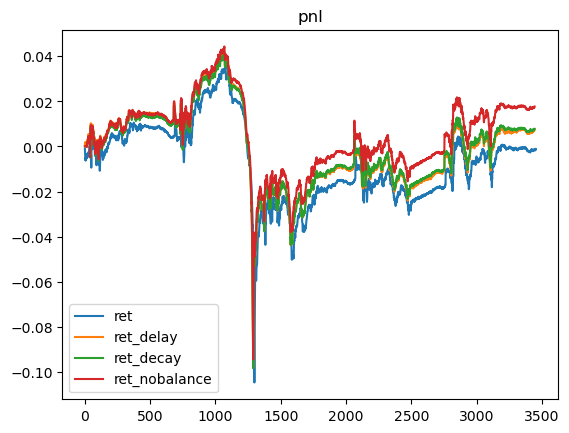

In [18]:
pd.DataFrame({
    "ret": pd.Series(returns),
    "ret_delay": pd.Series(returns_delay),
    "ret_decay": pd.Series(returns_decay),
    "ret_nobalance": pd.Series(returns_nobalance),
}).clip(-0.01,0.01).cumsum().plot(title="pnl")

<Axes: title={'center': 'turnover'}>

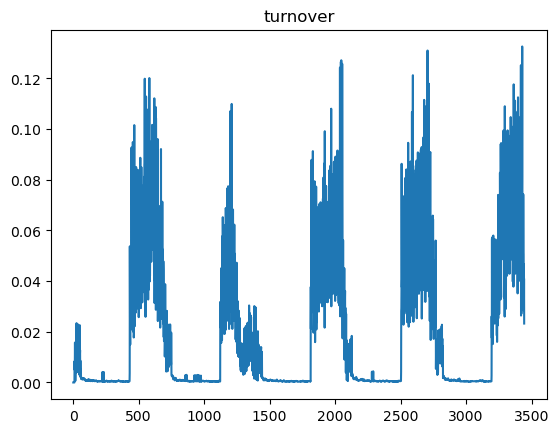

In [19]:
pd.DataFrame(avg_10(position[:-10])).diff().abs().sum(axis=1).plot(title="turnover")